In [76]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from PIL import Image

# Get video frame and duration

In [112]:
vid_path = "data/REC1136405714553569408.mp4"
vid_cap = cv2.VideoCapture(vid_path)

fps = vid_cap.get(cv2.CAP_PROP_FPS)
print("fps: " + str(fps))

length = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)
print("# video frames: " + str(length))

duration2 = (length/fps) * 1000
print("video duration: " + str(duration2))

fps: 29.38628252211245
# video frames: 101.0
video duration: 3436.977777777778


# Extract each frame in a video

In [185]:
def plot_image_and_label(image, label=["undf", np.inf, np.inf, np.inf]):
    
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''

    RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    Rotated_img = ndimage.rotate(RGB_img, 270)
    plt.imshow(Rotated_img)
    print("time stamp (ms): " + str(label[0]))
    print("pitch (x): " + str(label[1]))
    print("roll (y): " + str(label[2]))
    print("yaw (z): " + str(label[3]))
    plt.show()
    return

time stamp (ms): undf
pitch (x): inf
roll (y): inf
yaw (z): inf


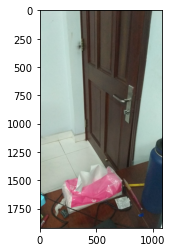

time stamp (ms): undf
pitch (x): inf
roll (y): inf
yaw (z): inf


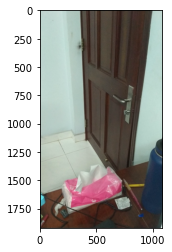

In [186]:
vid_path = "data/REC2019313338803235541.mp4"
vid_cap = cv2.VideoCapture(vid_path)
vid_cap.set(cv2.CAP_PROP_FPS, vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)-1)

res, frame = vid_cap.read()
plot_image_and_label(frame,)
res, frame = vid_cap.read()
plot_image_and_label(frame,)

# Processing the data
The following function will try to modify the csv file by adding/removing entries so that the # number of frames from CSV is equal to # frames from video. The purpose of this is so that we can have a one-to-one mapping for the CSV and MP4 files.

In [179]:
import csv
import math


def process_csv_data(fileName):
    vid_path = "data/" + fileName  + ".mp4"
    vid_cap = cv2.VideoCapture(vid_path)
    csv_path = "data/" + fileName + ".csv"

    fps = vid_cap.get(cv2.CAP_PROP_FPS)
    total_frames = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)
    video_duration = (total_frames/vid_cap.get(cv2.CAP_PROP_FPS)) * 1000


    with open(csv_path) as file:
        reader = csv.reader(file)
        data = list(reader)

    # Delete from the top of the file (due to sensors not ready)
    while (data[0][2] == data[1][2]) and (data[0][3] == data[1][3]) and (int(data[1][0]) - int(data[0][0]) < int(fps)) :
        data.remove(data[0])

    # Add empty entries for missing data
    while (int(data[0][0]) > 20):
        newValue = int(data[0][0]) - math.ceil(fps);
        if(newValue < math.ceil(fps)): #gurantees that the first entry will always be 0 (not that it's important)
            newValue = newValue - newValue
        data.insert(0, [newValue, np.inf, np.inf, np.inf])


    # Remove data that has timestamp that passes the video duration
        #if the abs difference in the last row and vid duration is greater than 2nd last row and vid duration
    while abs(int(data[len(data)-1][0]) - math.floor(video_duration)) > abs(int(data[len(data)-2][0]) - math.floor(video_duration)):
        data.remove(data[len(data)-1])


    #Difference of CSV - MP4
    differences_in_frames = len(data) - total_frames #Tell us if we are in excess or missing frames

    #Now we have the excess and we then add/remove entry depending if excessCount > 0 or < 0

    #if neg: missing frames (add null frames so differnce goes to 0; add inbetween timestamps with difference greater than about 2/3 the fps
    if(differences_in_frames < 0):
        index = 0
        while index < len(data) and differences_in_frames < 0: #Add null entry to the CSV
            timeDiff = int(data[index + 1][0]) - int(data[index][0])
            if( timeDiff >= (5.00/3.00) * math.ceil(fps)):
                data.insert(index+1, [int(timeDiff/2.0) + int(data[index][0]), np.inf, np.inf, np.inf])
                differences_in_frames += 1
                index += 1
            index += 1 

        if differences_in_frames < 0: #if still missing then add at the end
            while differences_in_frames < 0:
                data.insert(len(data), [int(data[len(data)][0]), np.inf, np.inf, np.inf])
                differences_in_frames += 1

    #if pos: excess frames (remove frames; remove one of the entires by slowly incrementing the diff in time between each frame

    if(differences_in_frames > 0):
        #Get list of things to remove
        index = 0
        removeMargin = 5
        while index < len(data) and differences_in_frames > 0:
            timeDiff = int(data[index + 1][0]) - int(data[index][0])
            if(timeDiff <= removeMargin):
                data.remove(data[index])
                differences_in_frames -= 1
                index -= 1
            index += 1
            if index == len(data):
                index = 0
                removeMargin += 5


    # data.insert(0, list({0,2,3,4}))
    # data.remove(data[1])

    with open('data/' + fileName + '_processed.csv', 'w', newline="") as f:
        write = csv.writer(f)
        write.writerows(data)

In [180]:
process_csv_data('REC1136405714553569408')

# Mapping data to each frame

time stamp (ms): 3439
pitch (x): -93.8333
roll (y): 76.8362
yaw (z): -30.5183


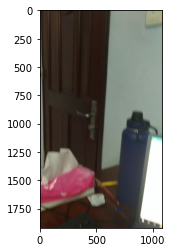

In [193]:
import os.path
from os import path
import time
from IPython.display import clear_output

file_name = "REC1136405714553569408"
processed_csv_path = "data/" + file_name + "_processed.csv"
if not path.exists(processed_csv_path):
    process_csv_data(file_name)

#Video File
vid_path = "data/" + file_name + ".mp4"
vid_cap = cv2.VideoCapture(vid_path)
vid_cap.set(cv2.CAP_PROP_FPS, vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)-1)

total_frames = vid_cap.get(cv2.CAP_PROP_FRAME_COUNT)

#CSV File
with open(processed_csv_path) as file:
    reader = csv.reader(file)
    csv_data = list(reader)

assert(len(csv_data) == int(total_frames))

#Loop through each and map
for i in range(int(total_frames)):
    res, frame = vid_cap.read()
    plot_image_and_label(frame,csv_data[i])
    time.sleep(0.2)
    clear_output(wait=True)
    